In [2]:
import tensorflow as tf
import numpy as np 
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.applications import (vgg16, ResNet50, densenet,
                                mobilenet_v2,
                                inception_resnet_v2,
                                inception_v3)


2025-12-23 20:58:53.520085: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 20:58:53.895082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-23 20:58:57.287110: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/juan-jose/tf-gpu1/lib/python3.12/site-packages/keras/src/expor

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np


# Cargar dataset
dataset, info = tfds.load('cats_vs_dogs', 
                          split='train',
                          as_supervised=True,
                          shuffle_files=True,
                          with_info=True)

total_size = info.splits['train'].num_examples

# División usando slices de TFDS (MÁS EFICIENTE)
train_split = 'train[:70%]'      # 70%
val_split = 'train[70%:85%]'     # 15%
test_split = 'train[85%:]'       # 15%

train_dataset = tfds.load('cats_vs_dogs', split=train_split, as_supervised=True)
validation_dataset = tfds.load('cats_vs_dogs', split=val_split, as_supervised=True)
test_dataset = tfds.load('cats_vs_dogs', split=test_split, as_supervised=True)

print(f"Entrenamiento: {len(list(train_dataset))} imágenes")
print(f"Validación: {len(list(validation_dataset))} imágenes")
print(f"Test: {len(list(test_dataset))} imágenes")

I0000 00:00:1766541542.001698   14624 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-12-23 20:59:02.653332: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-12-23 20:59:05.966896: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Entrenamiento: 16283 imágenes


2025-12-23 20:59:06.408377: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validación: 3490 imágenes
Test: 3489 imágenes


In [11]:
batch_size = 32
img_height = 224
img_width = 224

# 1. Preprocesamiento (redimensionar)
def preprocess(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)
# 2. BATCHING (¡ESENCIAL!)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 3. Verificación
print("=== VERIFICACIÓN FINAL ===")
for images, labels in train_dataset.take(1):
    print(f"Batch de imágenes: {images.shape}")  # Debe ser (32, 224, 224, 3)
    print(f"Batch de labels: {labels.shape}")    # Debe ser (32,)
    print(f"Rango de píxeles: {images.numpy().min():.2f} - {images.numpy().max():.2f}")

=== VERIFICACIÓN FINAL ===


2025-12-23 21:04:25.308294: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 616570880 bytes after encountering the first element of size 616570880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-12-23 21:04:25.309047: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 616570880 bytes after encountering the first element of size 616570880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Batch de imágenes: (32, 32, 224, 224, 3)
Batch de labels: (32, 32)
Rango de píxeles: 0.00 - 255.00


In [12]:
# 3. Verificación
print("=== VERIFICACIÓN FINAL ===")
for images, labels in test_dataset.take(1):
    print(f"Batch de imágenes: {images.shape}")  # Debe ser (32, 224, 224, 3)
    print(f"Batch de labels: {labels.shape}")    # Debe ser (32,)
    print(f"Rango de píxeles: {images.numpy().min():.2f} - {images.numpy().max():.2f}")

=== VERIFICACIÓN FINAL ===
Batch de imágenes: (32, 224, 224, 3)
Batch de labels: (32,)
Rango de píxeles: 0.00 - 255.00


In [5]:
#Configuracion del modelo base de la red
baseModel = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
#Congelamienta de capas ya entrenadas del modelo base 
for layer in baseModel.layers:
    layer.trainable = False
#Creacion del modelo de red neuronal principal y adicion del modelo base 
model = Sequential()
model.add(baseModel)

In [6]:
#Adicion de capas al modelo de red neuronal principal
#Capas de: Aumento de datos, normalización y salida 
model.add(RandomFlip("horizontal", input_shape=(224,224,3)))
model.add(RandomRotation(0.1))
model.add(RandomZoom(0.1))
model.add(Rescaling(1./255, input_shape=(224,224,3)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
print(model.summary())

/home/juan-jose/tf-gpu1/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 7, 7, 512)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,942,850 (68.45 MB)

 Trainable params: 3,228,162 (12.31 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [7]:
#Compilasion del modelo 
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

#model.compile(loss='categorial_crossentropy', optimizer=SGD(lr=1e-3), metrics=['accuracy'])

In [8]:
#Entrenamiento del modelo 
history = model.fit(train_dataset, validation_data= validation_dataset, epochs=1)
model.save('modelo_aprendizaje_por_transferenciaVGG16.h5')

2025-12-23 20:59:08.984680: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2025-12-23 20:59:10.177589: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


508/509 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9499 - loss: 0.1278

2025-12-23 21:01:30.550011: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


509/509 ━━━━━━━━━━━━━━━━━━━━ 176s 333ms/step - accuracy: 0.9627 - loss: 0.0953 - val_accuracy: 0.9705 - val_loss: 0.0804


['cat', 'dog']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


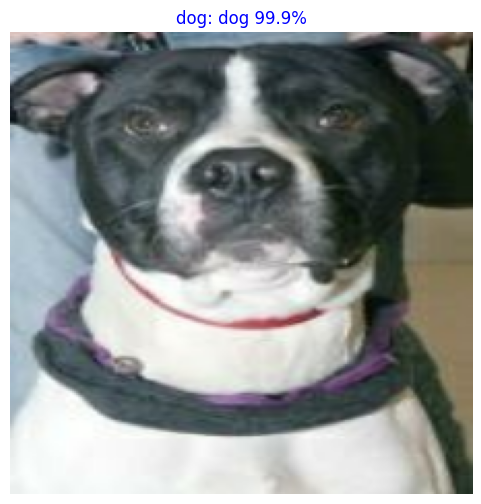

In [26]:
#Creacion de lotes de imagenes de prueba
#image_batch, label_batch = test_dataset.as_numpy_iterator().next()

image_batch, label_batch = test_dataset.as_numpy_iterator().next()

#Configuracion de variables para las graficas de salida
columns = 1
rows = 1
plt.figure(figsize=(15,6))

#Funcion para truncar la prediccion mumerica con decimales en el titulo 
class_names = info.features['label'].names
#imagenes
def truncate(number:float, max_decimals: int) -> float:
    int_part, dec_part = str(number).split(".")
    return float(f"{int_part}.{dec_part[:max_decimals]}")
    
#prediccion de las imagenes de prueba, se imprimen 9 imagenes de un lote
print(class_names)

#La prediccion aparece en el titulo de cada imagen
for i in range(1, columns*rows +1):
    imag_array = tf.expand_dims(image_batch[i], 0)
    prediccions = model.predict(imag_array)
    if class_names[label_batch[i]] == class_names[np.argmax(prediccions)]:

        color = 'blue'
    else:
        color = 'red'
    plt.subplot
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("{}: {} {}%".format(class_names[label_batch[i]], class_names[np.argmax(prediccions)],
                                   truncate(100*np.max(prediccions),1)),color=color)
    plt.axis('off')
    plt.show()


[[0.9961727  0.00382729]]
0
cat


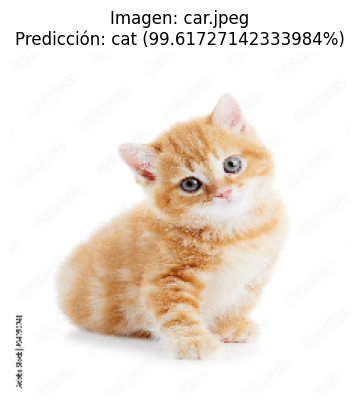

📊 Probabilidades: Gato: 99.6%, Perro: 0.4%


('cat', np.float32(99.61727), array([[0.9961727 , 0.00382729]], dtype=float32))

In [ ]:
def predecirUNaImagen(ruta, modelo, class_names, img_size = (224,224)):
    #cargar la imagen y pasarla al modelo 
    img = tf.keras.utils.load_img(ruta, target_size=img_size)
    #Volver la imagen un arreglo numpy y expandir dimensiones para que el modelo la pueda procesar
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0) 
    # 5. Hacer predicción
    predicciones = modelo.predict(img_array, verbose=0)
    
    # 6. Interpretar resultados
    clase_idx = np.argmax(predicciones[0])# Indice de la clase con mayor probabilidad, se pone [0] pues es una matriz de 1 fila y una columna
    print(predicciones)
    print(clase_idx)
    confianza = np.max(predicciones[0]) * 100#Vuelve porcentaje la prediccion
    clase_nombre = class_names[clase_idx]#obtiene el nombre de la clase
    print(clase_nombre)    
    # 7. Mostrar resultados
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)#muestra la imagen
    plt.title(f"Imagen: {ruta.split('/')[-1]}\nPredicción: {clase_nombre} ({confianza}%)")#le pone titulo a la imagen
    plt.axis('off')
    
   # plt.subplot(1, 2, 2)
    
    plt.tight_layout()
    plt.show()
    print(f"📊 Probabilidades: Gato: {predicciones[0][0]*100:.1f}%, Perro: {predicciones[0][1]*100:.1f}%")
    
    return clase_nombre, confianza, predicciones

predecirUNaImagen('car.jpeg'  , model, class_names) 

1
dog


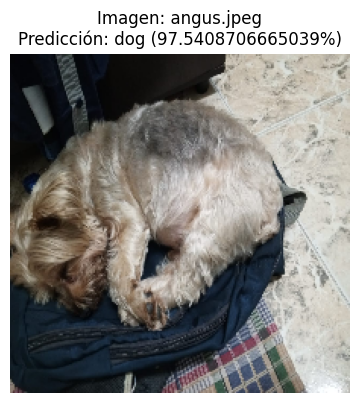

📊 Probabilidades: Gato: 2.5%, Perro: 97.5%
0
cat


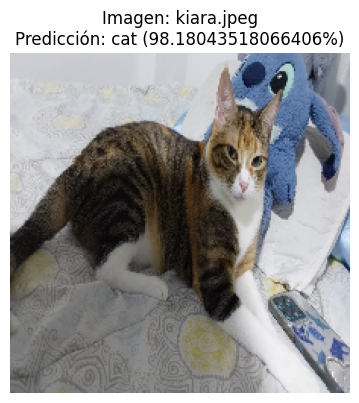

📊 Probabilidades: Gato: 98.2%, Perro: 1.8%


('cat',
 np.float32(98.180435),
 array([[0.9818044 , 0.01819571]], dtype=float32))

In [34]:
predecirUNaImagen('angus.jpeg', model, class_names)
predecirUNaImagen('kiara.jpeg' , model, class_names)